# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

# Import

In [149]:
import os
print(os.environ.get('TF_ENABLE_ONEDNN_OPTS'), os.environ.get('TF_CPP_MIN_LOG_LEVEL'))

import random
from collections import defaultdict
import numpy as np
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, AdditiveAttention, Concatenate
)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import string
import matplotlib.pyplot as plt

0 3


We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [150]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [151]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

In [152]:
# Let us define a simple dataset, and inspect a few samples.
X_train, Y_train = generate_dataset(10)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(10)
decoder_input_val = shift_right(Y_val)
i =  np.random.randint(10)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

6
infix :  ( d / a )
posfix notation:  d a /
teacher forcing :  SOS d a /


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [153]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.

---

# DL Project start 

Leonardo Billi 0001189587

06/25

## Seed

In [154]:
def set_global_seed(seed=42):
    print(f"global seed = {seed}.")

    # Seed Python
    random.seed(seed)

    # Seed NumPy
    np.random.seed(seed)

    # Seed TensorFlow
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)

    # Set determinism for TensorFlow
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 

SEED = 42
set_global_seed(SEED)

global seed = 42.


## MODEL


Si tratta di una traduzione seq2seq


Encoder–Decoder RNN with Attention (LSTM)

- **Principio**: un encoder Bi-LSTM o uni-LSTM legge la sequenza infissa e produce uno stato “contestualizzato” (hidden state) per ogni token. Un meccanismo di **attention** consente al decoder di “guardare” dinamicamente tutti i vettori di stato dell’encoder quando genera ogni token di output.
    
- **Motivazione**:
    
    1. Le espressioni infisse completamente parentizzate contengono molte parentesi “mute” in termini semantici, ma cruciali per la struttura. L’**attention** aiuta il decoder a focalizzarsi sui simboli giusti (parentesi, operatori, identificatori) nella giusta sequenza.
        
    2. Con profondità ≤ 3, la lunghezza massima di sequenza è contenuta, quindi una LSTM di dimensione media (p. es. 256–512 unità) è sufficiente per rappresentare tutte le strutture possibili.

- **Struttura proposta**:
    
    1. **Embedding** : Si può usare un embedding di dimensione ridotta (p.es. 64–128) per trasformare ID token in vettori densi.
        
    2. **Encoder**:
        
        - **Input**: sequenza infissa codificata `[batch_size, MAX_LEN]`;
            
        - **Layer**: `Embedding(VOCAB_SIZE, d_emb)` → `Bidirectional(LSTM(units=units_e, return_sequences=True, return_state=True))`.
            
        - **Output**: sequenza di stati `encoder_outputs` ([batch_size, MAX_LEN, 2·units_e]) e stati finali `h_enc`, `c_enc` (solo se LSTM).
            
    3. **Decoder**:
        
        - **Input**: sequenza di “decoder input” (teacher forcing) `[batch_size, MAX_LEN]`;
            
        - **Layer**: `Embedding(VOCAB_SIZE, d_emb)` → `LSTM(units=units_d, return_sequences=True, return_state=True)` con initial state settati a `h_enc`, `c_enc` ([machinelearningmastery.com](https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/?utm_source=chatgpt.com "How to Develop a Seq2Seq Model for Neural Machine Translation in Keras - MachineLearningMastery.com"), [tensorflow.org](https://www.tensorflow.org/text/tutorials/nmt_with_attention?utm_source=chatgpt.com "Neural machine translation with attention  |  Text  |  TensorFlow")).
            
        - **Attention**: usare un meccanismo di attention “bahdanau”.
             $$
                e_{t,i} = v^\top \tanh\bigl(W_q\,h_t + W_k\,H_i\bigr)
            $$
            
        - **Dense finale**: `TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))`.

Scelta finale e motivazioni  

**Consigliamo vivamente l’encoder–decoder RNN con attention** (LSTM/GRU) in quanto:

1. **Semplicità di implementazione** in Keras (basta seguire l’esempio di Francois Chollet).
    
2. **Ottima capacità di catturare gerarchie** fino a profondità 3, grazie all’attenzione che aiuta a bypassare il “vanishing gradient” su sequenze con molte parentesi.
    
3. **Parametri contenuti**: con `units_e = units_d = 256` e embedding 128 (oppure 512+256 per unità, sempre restando sotto i 2 M), mantiene un buon margine di manovra per hyperparameter tuning (dropout, regularization).


“A ten-minute introduction to sequence-to-sequence learning in Keras” di Francois Chollet, che mostra come definire encoder–decoder LSTM con input/padding fisso ([machinelearningmastery.com](https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/?utm_source=chatgpt.com "How to Develop a Seq2Seq Model for Neural Machine Translation in Keras - MachineLearningMastery.com")).

In [155]:
def create_encoder_model(vocab_size, embed_dim, enc_units, max_len):
    enc_inputs = Input(shape=(max_len,), name="enc_inputs")
    x = Embedding(input_dim=vocab_size,
                  output_dim=embed_dim,
                  mask_zero=False,
                  name="enc_embedding")(enc_inputs)
    enc_outputs, state_h, state_c = LSTM(enc_units,
                                         return_sequences=True,
                                         return_state=True,
                                         name="encoder_lstm")(x)
    return Model(enc_inputs, [enc_outputs, state_h, state_c], name="encoder_model")

In [156]:
def create_decoder_model(vocab_size, embed_dim, dec_units, max_len, enc_units):
    # Inputs
    dec_inputs   = Input(shape=(max_len,), name="dec_inputs")     # teacher-forcing
    enc_outputs  = Input(shape=(max_len, enc_units), name="enc_outs")
    state_h_in   = Input(shape=(dec_units,), name="h_in")
    state_c_in   = Input(shape=(dec_units,), name="c_in")

    # Embedding + LSTM
    x  = Embedding(input_dim=vocab_size,
                   output_dim=embed_dim,
                   mask_zero=False,
                   name="dec_embedding")(dec_inputs)
    dec_outputs, state_h_out, state_c_out = LSTM(dec_units,
                                                return_sequences=True,
                                                return_state=True,
                                                name="decoder_lstm")(
        x, initial_state=[state_h_in, state_c_in]
    )

    # Attention
    context = AdditiveAttention(name="attention")(
        [dec_outputs, enc_outputs]
    )
    concat = Concatenate(axis=-1, name="concat")([dec_outputs, context])

    # Proiezione
    logits = Dense(vocab_size, activation="softmax", name="vocab_dist")(concat)

    return Model(
        [dec_inputs, enc_outputs, state_h_in, state_c_in],
        [logits, state_h_out, state_c_out],
        name="decoder_model"
    )


In [157]:
def create_seq2seq_model(encoder, decoder, max_len):
    # encoder.input è l’encoder_inputs, decoder.input[0] è decoder_inputs
    enc_in = encoder.input                                # (batch, max_len)
    dec_in = decoder.input[0]                             # (batch, max_len)
    
    # 1. forward through encoder
    enc_outs, h, c = encoder(enc_in)
    
    # 2. forward through decoder (teacher forcing)
    logits, _, _ = decoder([dec_in, enc_outs, h, c])
    
    # full model
    return Model([enc_in, dec_in], logits, name="seq2seq_model")

In [158]:
EMBED_DIM  = 32
ENC_UNITS = 256   
DEC_UNITS = 256

encoder = create_encoder_model(VOCAB_SIZE, EMBED_DIM, ENC_UNITS, MAX_LEN)
decoder = create_decoder_model(VOCAB_SIZE, EMBED_DIM, DEC_UNITS, MAX_LEN, ENC_UNITS)
seq2seq = create_seq2seq_model(encoder, decoder, MAX_LEN)

encoder.summary()
decoder.summary()
seq2seq.summary()

Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_inputs (InputLayer)         │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_embedding (Embedding)       │ (None, 30, 32)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ [(None, 30, 256),      │       295,936 │
│                                 │ (None, 256), (None,    │               │
│                                 │ 256)]                  │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,416 (1.13 MB)

 Trainable params: 296,416 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dec_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding       │ (None, 30, 32)    │        480 │ dec_inputs[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h_in (InputLayer)   │ (None, 256)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c_in (InputLayer)   │ (None, 256)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 30, 256), │    295,936 │ dec_embedding[0]… │
│                     │ (None, 256),      │            │ h_in[0][0],       │
│                     │ (None, 256)]      │            │ c_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_outs            │ (None, 30, 256)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 256)   │        256 │ decoder_lstm[0][… │
│ (AdditiveAttention) │                   │            │ enc_outs[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 30, 512)   │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vocab_dist (Dense)  │ (None, 30, 15)    │      7,695 │ concat[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 304,367 (1.16 MB)

 Trainable params: 304,367 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_model       │ [(None, 30, 256), │    296,416 │ enc_inputs[0][0]  │
│ (Functional)        │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_model       │ [(None, 30, 15),  │    304,367 │ dec_inputs[0][0], │
│ (Functional)        │ (None, 256),      │            │ encoder_model[0]… │
│                     │ (None, 256)]      │            │ encoder_model[0]… │
│                     │                   │            │ encoder_model[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 600,783 (2.29 MB)

 Trainable params: 600,783 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

## Dataset

In [159]:
# Same as generate_dataset but returns also the expression
def generate_dataset_express(n,max_depth=MAX_DEPTH):
    X, Y, Expr = [], [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
        Expr.append(expr)
    return np.array(X), np.array(Y), Expr

def analize_dataset(data, max_depth=MAX_DEPTH):

    idx_map = defaultdict(list)
    for idx, key in enumerate(data):
        idx_map[key].append(idx)    #for each string in data, keep track of all its indices
    counts = {key: len(idxs) for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of hpw many duplicates there are
    duplicates = {key: idxs for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of all its indices
    total = sum(counts.values()) 

    print(f"Found {len(duplicates)} duplicate string with totla counts: {total}")
    print(f"the percentage of duplicates is: {total / len(data) * 100}%")
    print("the top 10 duplicates are:")
    for key, idxs in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {key} = {idxs}")

    return duplicates, counts


In [160]:
sizes = [20, 1_000, 5_000, 10_000, 100_000]
for size in sizes:
    print(f"Generating dataset of size {size}...")
    _, _, Expr = generate_dataset_express(size)
    duplicates, _ = analize_dataset(Expr)
    print(f"Dataset of size {size} generated with {len(duplicates)} duplicates.")
    print("-" * 50)

Generating dataset of size 20...
Found 0 duplicate string with totla counts: 0
the percentage of duplicates is: 0.0%
the top 10 duplicates are:
Dataset of size 20 generated with 0 duplicates.
--------------------------------------------------
Generating dataset of size 1000...
Found 77 duplicate string with totla counts: 323
the percentage of duplicates is: 32.300000000000004%
the top 10 duplicates are:
  c = 30
  e = 24
  d = 23
  a = 19
  b = 16
  (e - d) = 7
  (c - a) = 6
  (a - c) = 6
  (d - e) = 6
  (e - c) = 6
Dataset of size 1000 generated with 77 duplicates.
--------------------------------------------------
Generating dataset of size 5000...
Found 240 duplicate string with totla counts: 2021
the percentage of duplicates is: 40.42%
the top 10 duplicates are:
  d = 136
  b = 125
  e = 121
  c = 111
  a = 100
  (d + a) = 20
  (b / a) = 18
  (e * b) = 18
  (a * e) = 18
  (e - e) = 17
Dataset of size 5000 generated with 240 duplicates.
----------------------------------------------

Nonostante sia una regola generale piu il dataset e' grosso meglio e'. In questo caso abbiamo che maggiore e' il dataset, maggiori saranno i duplicati per lunghezze piccole, mentre piu' sara' piccolo il dataset meno diversificazione del delle stringhe lunghe avremo
cerchiamo compromesso

In [161]:
N_SAMPLES = 10_000
X, Y, expr = generate_dataset_express(N_SAMPLES)

In [162]:
duplicates, counts = analize_dataset(expr)#, regenerate=True

Found 539 duplicate string with totla counts: 4398
the percentage of duplicates is: 43.980000000000004%
the top 10 duplicates are:
  a = 278
  c = 255
  e = 245
  b = 241
  d = 227
  (c * c) = 35
  (d / b) = 34
  (b - c) = 33
  (c * b) = 31
  (c + e) = 30


In [163]:
decoder_input = shift_right(Y)

# 10 % validation set
X_train, X_val, dec_in_train, dec_in_val, Y_train, Y_val = train_test_split(
    X, decoder_input, Y,
    test_size=0.1,
    random_state=SEED
)

batch piu' grande servoni piu epoche per fare buoni risulati (forse troppi duplicati su singoli batch)

patience = 3{
con 128 servono 15 20 epoche e comunqu non arriva a 1   
con 64 FINAL SCORE = 0.9923 STD = 0.0095 dopo 10 epoche  
con 32 dop 9 epoche ho tutti 1 
con 16 dopo 7 epoche FINAL SCORE = 0.9993 STD = 0.0021
}  

patience = 5 



In [164]:
BATCH_SIZE = 16
BUFFER_SIZE = len(X_train)

def make_dataset(enc_in, dec_in, target):
    ds = tf.data.Dataset.from_tensor_slices(((enc_in, dec_in), target))
    ds = ds.shuffle(BUFFER_SIZE, seed=SEED) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, dec_in_train, Y_train)
val_ds   = make_dataset(X_val,   dec_in_val,   Y_val)

## Evaluate functions

In [165]:
def autoregressive_decode(encoder_input):
    enc_in = encoder_input[None, :] # Add batch dimension
    enc_outs, h, c = encoder.predict(enc_in, verbose=0)

    token = np.array([[SOS_ID]])
    output_seq = []
    for _ in range(MAX_LEN):
        logits, h, c = decoder.predict([token, enc_outs, h, c], verbose=0)
        # greedy decoding
        sampled_id = np.argmax(logits[0, 0, :])
        output_seq.append(sampled_id)
        if sampled_id == EOS_ID:
            break
        token = np.array([[sampled_id]])
    return output_seq

def test(no=20,rounds=10,max_depth=MAX_DEPTH,verbose_n=0):  # added max depth and verbose
  rscores =[]
  for i in range(rounds):

    print("================================================")             # added
    print(f"round={i}")
    print("------------------------------------------------")             # added
    X_test, Y_test = generate_dataset(no, max_depth)                      # added max depth
    scores = []
    n = verbose_n                                                         # added
    for j in range(no): 
      if n < (no+1):                                                      # added     
        if n <= 0:                                                        # added
          verbose = False                                                 # added
        else:                                                             # added
          verbose = True                                                  # added  
        n -= 1                                                            # added
      encoder_input=X_test[j]
      generated = autoregressive_decode(encoder_input)                    # [1:] In my case no nedd to remove SOS, the function returns it whitout
      if verbose:                                                         # added
        print(f"~~~~~ es number {j} ~~~~~")                               # added
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token, verbose=verbose))
    if verbose_n > 0:                                                     # added
      print("------------------------------------------------")           # added
    print(f"mean scores={np.mean(scores):.4f} std={np.std(scores):.4f}")  # added
    
    rscores.append(np.mean(scores))
  mean_pref_acc = np.mean(rscores)
  std_pref_acc = np.std(rscores)
  print("================================================")       # added
  print(f"FINAL SCORE = {mean_pref_acc:.4f} STD = {std_pref_acc:.4f}")# added
  return mean_pref_acc,std_pref_acc

## Training

In [166]:
class PrefixAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, id_to_token):
        super().__init__()
        # Validation data generated on the fly, total 4 sets of 25 samples each
        # this to metch with the test() function in the notebook
        X_Y_val = []
        for i in range(4):
            X_Y_val.append(generate_dataset(25))
        self.X_val = [x for x, _ in X_Y_val]
        self.Y_val = [y for _, y in X_Y_val]
        self.id_to_token = id_to_token
        self.history = [] # to store the prefix accuracy for each epoch

    def on_epoch_end(self, epoch, logs=None):
        mscores = []
        for i in range(len(self.X_val)):
            X_temp, Y_temp = self.X_val[i], self.Y_val[i]
            scores = [
                prefix_accuracy_single(y, autoregressive_decode(x), self.id_to_token)
                for x, y in zip(X_temp, Y_temp)
            ]
            mean_score = np.mean(scores)
            mscores.append(mean_score)
        mean_mean_score = np.mean(mscores)
        self.history.append(mean_mean_score)
        logs = logs or {}
        logs['val_prefix_acc'] = mean_mean_score
        print(f" — val_prefix_acc: {mean_mean_score:.4f}")

In [167]:
# 1) Definisci un Callback che salva i valori batch-wise
class BatchMetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []
        self.batch_acc    = []
    def on_train_batch_end(self, batch, logs=None):
        # logs contiene 'loss' e la tua metrica compilata, es. 'sparse_categorical_accuracy'
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['sparse_categorical_accuracy'])

In [168]:
class NamedEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, name, **kwargs):
        super().__init__(**kwargs)
        self._name = name

    def on_train_end(self, logs=None):
        # se stopped_epoch > 0 => questo callback ha deciso di fermare
        if self.stopped_epoch > 0:
            print(f"EarlyStopping “{self._name}” (epoch {self.stopped_epoch})")
        super().on_train_end(logs)

In [169]:
EPOCHS = 30

batch_cb  = BatchMetricsCallback()
prefix_cb = PrefixAccuracyCallback(id_to_token)

es = NamedEarlyStopping(
    name="val_loss",
    monitor="val_loss",
    patience=3,
    min_delta=0.005,
    restore_best_weights=True
)

es_prefix = NamedEarlyStopping(
    name="val_prefix_acc",
    monitor="val_prefix_acc",
    mode="max",
    patience=3,
    min_delta=0.001,
    restore_best_weights=True
)

seq2seq.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

history = seq2seq.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[batch_cb, prefix_cb,es, es_prefix]
)

Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5921 - sparse_categorical_accuracy: 0.8078 — val_prefix_acc: 0.2816
563/563 ━━━━━━━━━━━━━━━━━━━━ 53s 92ms/step - loss: 0.5918 - sparse_categorical_accuracy: 0.8078 - val_loss: 0.3259 - val_sparse_categorical_accuracy: 0.8605 - val_prefix_acc: 0.2816
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2876 - sparse_categorical_accuracy: 0.8783 — val_prefix_acc: 0.6822
563/563 ━━━━━━━━━━━━━━━━━━━━ 51s 90ms/step - loss: 0.2875 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.1883 - val_sparse_categorical_accuracy: 0.9217 - val_prefix_acc: 0.6822
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1389 - sparse_categorical_accuracy: 0.9443 — val_prefix_acc: 0.9273
563/563 ━━━━━━━━━━━━━━━━━━━━ 50s 89ms/step - loss: 0.1389 - sparse_categorical_accuracy: 0.9443 - val_loss: 0.0358 - val_sparse_categorical_accuracy: 0.9888 - val_prefix_acc: 0.9273
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 

In [170]:
# Controlla chi ha fermato il training
stop_callbacks = []
for cb in (es, es_prefix):
    if hasattr(cb, 'stopped_epoch') and cb.stopped_epoch > 0:
        stop_callbacks.append((cb._name, cb.stopped_epoch))

if not stop_callbacks:
    print("➡️ Nessun EarlyStopping ha fermato il training.")
else:
    # ordina per epoca di stop
    stop_callbacks.sort(key=lambda x: x[1])
    name, epoch = stop_callbacks[0]
    print(f"⁉️ Training interrotto da EarlyStopping “{name}” all'epoca {epoch}.")

⁉️ Training interrotto da EarlyStopping “val_loss” all'epoca 6.


## Evaluation

In [171]:
mean_pref_acc, std_pref_acc = test(verbose_n=3)

round=0
------------------------------------------------
~~~~~ es number 0 ~~~~~
TARGET : b d + e b + -
PREDICT: b d + e b + -
PREFIX MATCH: 7/7 → 1.00
~~~~~ es number 1 ~~~~~
TARGET : d a a / - d a - -
PREDICT: d a a / - d a - -
PREFIX MATCH: 9/9 → 1.00
~~~~~ es number 2 ~~~~~
TARGET : a e c - * e e / -
PREDICT: a e c - * e e / -
PREFIX MATCH: 9/9 → 1.00
------------------------------------------------
mean scores=1.0000 std=0.0000
round=1
------------------------------------------------
~~~~~ es number 0 ~~~~~
TARGET : e b + d /
PREDICT: e b + d /
PREFIX MATCH: 5/5 → 1.00
~~~~~ es number 1 ~~~~~
TARGET : e b / d /
PREDICT: e b / d /
PREFIX MATCH: 5/5 → 1.00
~~~~~ es number 2 ~~~~~
TARGET : a a c - * e b - /
PREDICT: a a c - * e b - /
PREFIX MATCH: 9/9 → 1.00
------------------------------------------------
mean scores=1.0000 std=0.0000
round=2
------------------------------------------------
~~~~~ es number 0 ~~~~~
TARGET : c b * b e * /
PREDICT: c b * b e * /
PREFIX MATCH: 7/7 → 1.0

In [172]:
for depth in range(3,10):
    print(f"~~~~~~~~~~Testing with max_depth={depth}~~~~~~~~~~~~")
    mean_pref_acc, std_pref_acc = test(rounds=2,max_depth=depth, verbose_n=2)

~~~~~~~~~~Testing with max_depth=3~~~~~~~~~~~~
round=0
------------------------------------------------
~~~~~ es number 0 ~~~~~
TARGET : b e +
PREDICT: b e +
PREFIX MATCH: 3/3 → 1.00
~~~~~ es number 1 ~~~~~
TARGET : b b +
PREDICT: b b +
PREFIX MATCH: 3/3 → 1.00
------------------------------------------------
mean scores=0.9909 std=0.0396
round=1
------------------------------------------------
~~~~~ es number 0 ~~~~~
TARGET : a e / c c + +
PREDICT: a e / c c + +
PREFIX MATCH: 7/7 → 1.00
~~~~~ es number 1 ~~~~~
TARGET : e e +
PREDICT: e e +
PREFIX MATCH: 3/3 → 1.00
------------------------------------------------
mean scores=1.0000 std=0.0000
FINAL SCORE = 0.9955 STD = 0.0045
~~~~~~~~~~Testing with max_depth=4~~~~~~~~~~~~
round=0
------------------------------------------------
~~~~~ es number 0 ~~~~~
TARGET : b c +
PREDICT: b c +
PREFIX MATCH: 3/3 → 1.00
~~~~~ es number 1 ~~~~~
TARGET : d e +
PREDICT: d e +
PREFIX MATCH: 3/3 → 1.00
------------------------------------------------
mean

## Plot

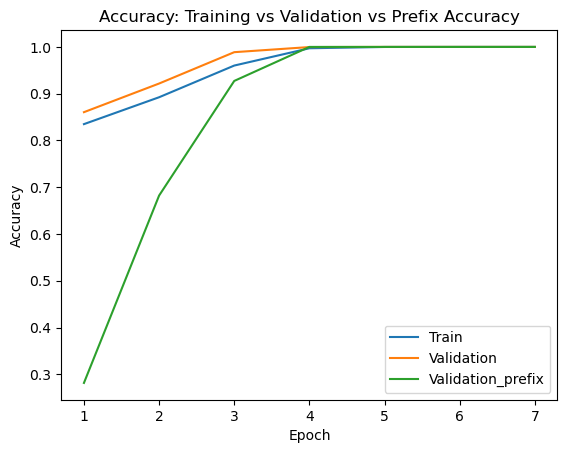

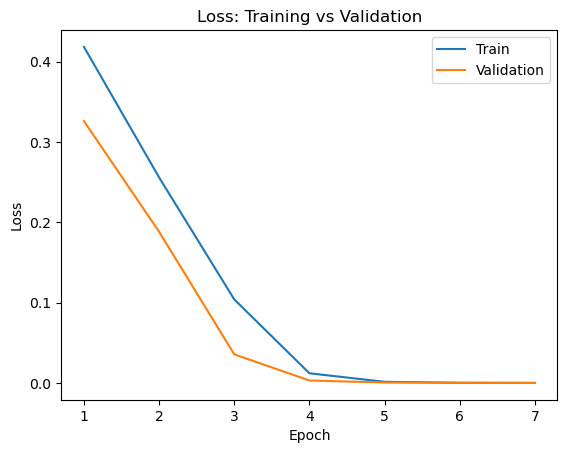

In [178]:
# 1) Estrai le curve di training/validation dal History
acc       = history.history['sparse_categorical_accuracy']
val_acc   = history.history['val_sparse_categorical_accuracy']
loss      = history.history['loss']
val_loss  = history.history['val_loss']
epochs    = range(1, len(acc) + 1)

# 2) Grafico accuracy
plt.figure()
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.plot(epochs, prefix_cb.history)
plt.title('Accuracy: Training vs Validation vs Prefix Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation', 'Validation_prefix'], loc='lower right')
plt.show()  # :contentReference[oaicite:0]{index=0}

# 3) Grafico loss
plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss: Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()  # :contentReference[oaicite:1]{index=1}

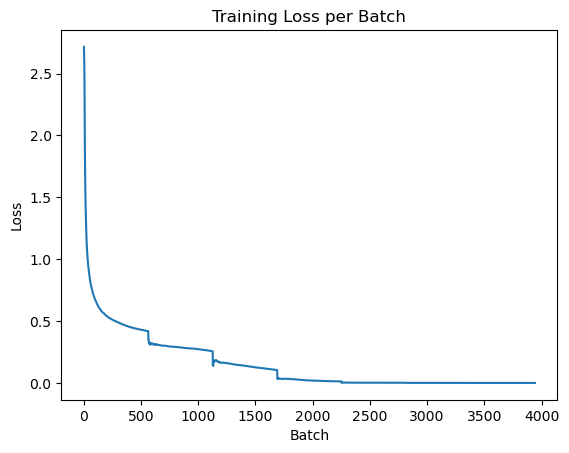

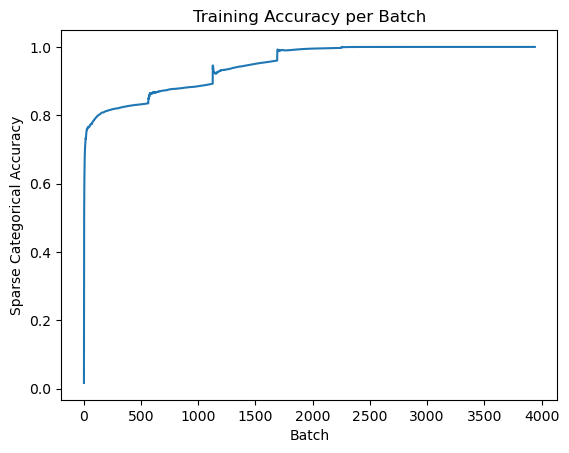

In [174]:
# X: indice del batch (0,1,2,…)
batches = range(1, len(batch_cb.batch_losses) + 1)

# Figura 1: Loss per batch
plt.figure()
plt.plot(batches, batch_cb.batch_losses)
plt.title('Training Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

# Figura 2: Accuracy per batch
plt.figure()
plt.plot(batches, batch_cb.batch_acc)
plt.title('Training Accuracy per Batch')
plt.xlabel('Batch')
plt.ylabel('Sparse Categorical Accuracy')
plt.show()

## Conclusion

In [175]:
# model.save_weights('progettoDL/seq2seq_attention_v0.weights.h5')
seq2seq.summary()

Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_model       │ [(None, 30, 256), │    296,416 │ enc_inputs[0][0]  │
│ (Functional)        │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_model       │ [(None, 30, 15),  │    304,367 │ dec_inputs[0][0], │
│ (Functional)        │ (None, 256),      │            │ encoder_model[0]… │
│                     │ (None, 256)]      │            │ encoder_model[0]… │
│                     │                   │            │ encoder_model[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,802,351 (6.88 MB)

 Trainable params: 600,783 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,201,568 (4.58 MB)

---

In [176]:
import  numpy as np
print("NumPy:", np.__version__)

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("tf:",tf.__version__)

import keras
print(keras.__version__)

NumPy: 2.0.2
[]
tf: 2.18.0
3.8.0


---
# Migliorie
- due dizionari separati
- mask accuracy

In [177]:
def dedupe_dataset(data, max_depth=MAX_DEPTH, regenerate=False):

    idx_map = defaultdict(list)
    for idx, key in enumerate(data):
        idx_map[key].append(idx)    #for each string in data, keep track of all its indices
    counts = {key: len(idxs) for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of hpw many duplicates there are
    duplicates = {key: idxs for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of all its indices
    total = sum(counts.values()) 

    print(f"Found {len(duplicates)} duplicate string with totla counts: {total}")
    print(f"the percentage of duplicates is: {total / len(data) * 100}%")
    print("the top 10 duplicates are:")
    for key, idxs in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {key} = {idxs}")
    # if regenerate:
    #     # 4) Per ogni chiave duplicata, rigenera nuovi esempi
    #     for key, idxs in duplicates.items():
    #         # mantieni la prima occorrenza, rigenera le altre
    #         for dup_idx in idxs[1:]:
    #             # calcola la lunghezza target (fino a EOS)
    #             seq = X[dup_idx]
    #             # EOS_ID è definito globalmente
    #             eos_pos = np.where(seq == EOS_ID)[0][0] + 1
    #             target_len = eos_pos  # numero di token inclusi EOS

    #             # rigenera fino a ottenere la stessa lunghezza
    #             while True:
    #                 # genera singolo esempio
    #                 x_new, y_new = generate_dataset(1, max_depth)
    #                 x_new = x_new[0]
    #                 y_new = y_new[0]
    #                 # trova eos nella nuova x
    #                 eos_new = np.where(x_new == EOS_ID)[0][0] + 1
    #                 if eos_new == target_len:
    #                     # accetta questa coppia
    #                     X[dup_idx] = x_new
    #                     Y[dup_idx] = y_new
    #                     break
        # dopo la rigenerazione, i duplicati originali sono stati sostituiti
        # ricostruisci le mappe se serve
        # (opzionale) si può riloggare quante rigenerazioni sono avvenute

    return duplicates, counts
